# Multilinear regression with the Ames Housing data

# Dataset

We will take a look at the Ames housing data from [Veridical Data
Science by Yu and Barter](https://vdsbook.com/). It is also available on
the course website in the [datasets page](../datasets/data.html). [(The
original data is on
github.)](https://github.com/Yu-Group/vds-book-supplementary)

These are a sample of homes sold in Ames Iowas between 2006 and 2010 as
recorded by the city assessor’s office. [See the discussion in Chapter
8.4 of VDS.](https://vdsbook.com/08-prediction_intro#sec-ames-intro).

We will be looking at this data to ask the question: how much might I
increase my home’s value by renovating the kitchen?

The dataset lists sale price, as well as different “kitchen quality”
measures:

    KitchenQual (Ordinal): Kitchen quality
           Ex       Excellent
           Gd       Good
           TA       Typical/Average
           Fa       Fair
           Po       Poor

In [2]:
git_repo_dir <- "/home/rgiordan/Documents/git_repos/stat151a"
housing_dir <- file.path(git_repo_dir, "datasets/ames_house/data")
ames_orig <- read.table(file.path(housing_dir, "AmesHousing.txt"), sep="\t", header=T)

We will follow some of the cleaning suggestions in the [VDS
book](https://vdsbook.com/08-prediction_intro#sec-cleaning-ames).

We’ll also look only at “good” and “excellent” kitchens, on the
assumption that we are upgrading our kitchen from its present “good”
condtion to “excellent.”

In [4]:
ames <- ames_orig %>%
  filter(Sale.Condition == "Normal",
         # remove agricultural, commercial and industrial
         !(MS.Zoning %in% c("A (agr)", "C (all)", "I (all)"))) %>%
  filter(Kitchen.Qual %in% c("Gd", "Ex")) %>%
  mutate(Overall.Qual=factor(Overall.Qual))

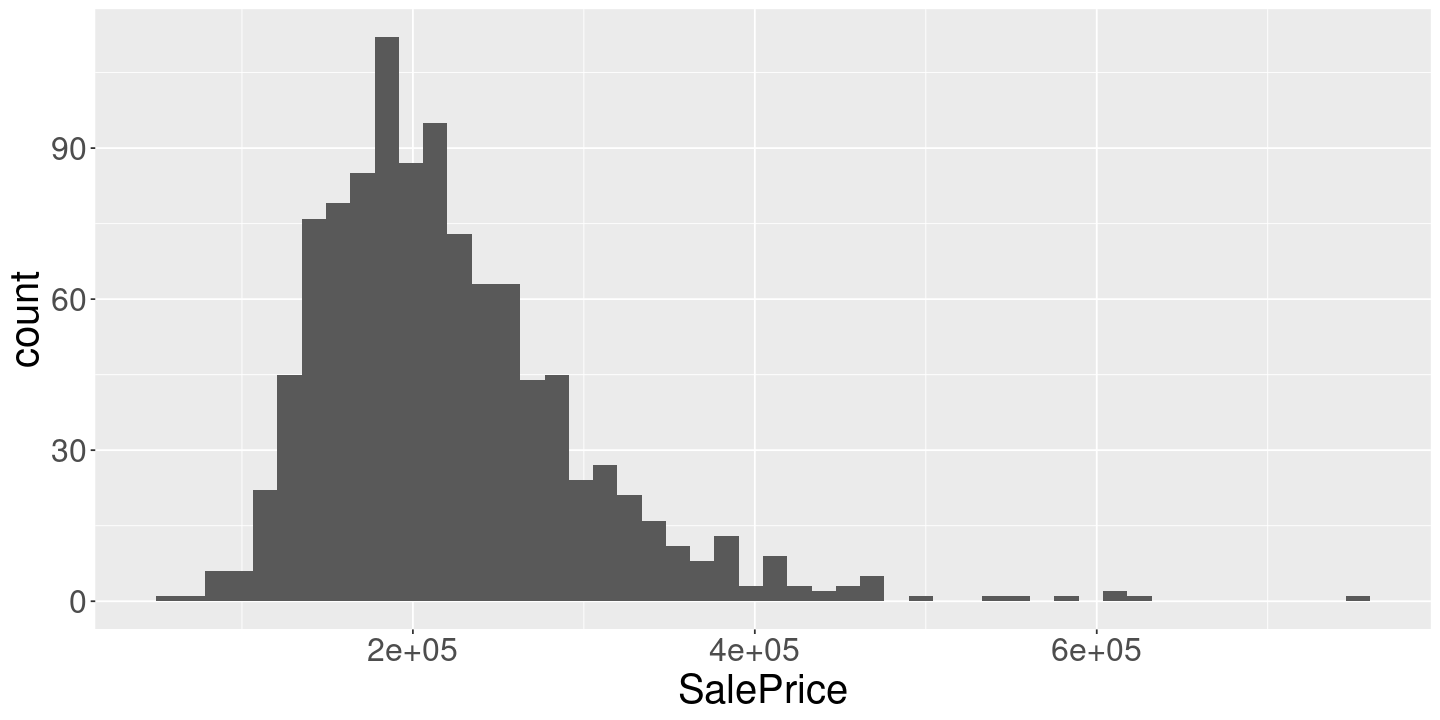

In [7]:
ggplot(ames) + 
geom_histogram(aes(x=SalePrice), bins=50)

# Inference

One way we might ask much we increase the home’s value by upgrading the
kitchen is to look at the mean sales price for both good and excellent
kitchens.

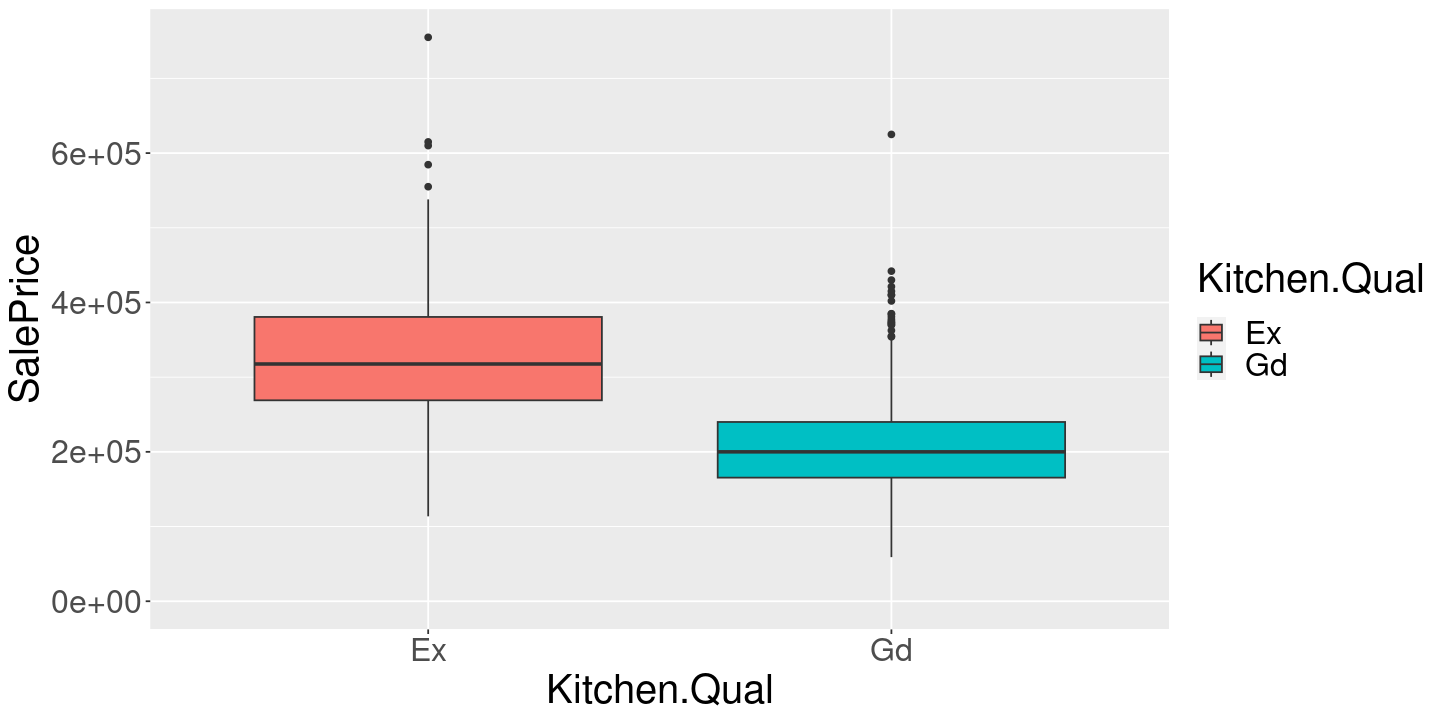

In [8]:
ames %>%
  ggplot() +
      geom_boxplot(aes(x=Kitchen.Qual, y=SalePrice, fill=Kitchen.Qual))+
      expand_limits(y=0)

In [9]:
mean_diff <- 
    ames %>%
        group_by(Kitchen.Qual) %>%
        summarize(mean_price=mean(SalePrice)) %>%
        pivot_wider(names_from=Kitchen.Qual, values_from=mean_price) %>%
        mutate(difference=Ex - Gd)

print(mean_diff)

# A tibble: 1 × 3
       Ex      Gd difference
    <dbl>   <dbl>      <dbl>
1 327007. 207828.    119179.

The difference is quite large! Maybe upgrading your kitchen is a great
investment.

## Viewing the difference of means as a regression

Note that we can compute the same thing with a regression.

In [10]:
reg <- lm(SalePrice ~ Kitchen.Qual - 1, ames)
print(summary(reg))


Call:
lm(formula = SalePrice ~ Kitchen.Qual - 1, data = ames)

Residuals:
    Min      1Q  Median      3Q     Max 
-213307  -44953   -7878   35297  427993 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
Kitchen.QualEx   327006       6305   51.87   <2e-16 ***
Kitchen.QualGd   207828       2215   93.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 67910 on 1054 degrees of freedom
Multiple R-squared:  0.916, Adjusted R-squared:  0.9158 
F-statistic:  5747 on 2 and 1054 DF,  p-value: < 2.2e-16


What is going on? When we run the regression, R is converting
`Kitchen.Qual` into a binary matrix.

In [11]:
x <- model.matrix(SalePrice ~ Kitchen.Qual - 1, ames)

bind_cols(
    select(ames, Kitchen.Qual),
    x) %>% 
head(, 10)

We then find the coefficients $\beta_{ex}$ and $\beta_{gd}$ that
minimizes

$$
\sum_{n=1}^N (y_n - (\beta_{ex} \textrm{Kitchen.QualEx} + \beta_{gd} \textrm{Kitchen.QualGd}))^2
$$

where $y_n =$`SalePrice`.

Exercise: prove that the optimal values, $\hat\beta_{ex}$ and
$\hat\beta_{gd}$, are just the sample means within their respective
categories, e.g.

$$
\hat\beta_{ex} = \frac{1}{N_{ex}} \sum_{n: \textrm{Kitchen.Qual} = \textrm{Ex}} y_n
$$

There are a couple ways to get the difference out of `R`.

In [ ]:
predict(reg, data.frame(Kitchen.Qual="Ex")) - predict(reg, data.frame(Kitchen.Qual="Gd"))

In [ ]:
betahat <- coefficients(reg)
diff <- betahat["Kitchen.QualEx"] - betahat["Kitchen.QualGd"]
names(diff) <- NULL
print(diff)

Here’s one you might not have thought of:

In [12]:
reg2 <- lm(SalePrice ~ Kitchen.Qual + 1, ames)
print(summary(reg2))


Call:
lm(formula = SalePrice ~ Kitchen.Qual + 1, data = ames)

Residuals:
    Min      1Q  Median      3Q     Max 
-213307  -44953   -7878   35297  427993 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      327006       6305   51.87   <2e-16 ***
Kitchen.QualGd  -119178       6683  -17.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 67910 on 1054 degrees of freedom
Multiple R-squared:  0.2318,    Adjusted R-squared:  0.2311 
F-statistic:   318 on 1 and 1054 DF,  p-value: < 2.2e-16


Here, the model includes a constant, which is always 1. Then it includes
an encoding vector only for `Kitchen.QualGd`.

Exercise: Why doesn’t it include one for `Kitchen.QualEx`?

In [13]:
x <- model.matrix(SalePrice ~ Kitchen.Qual + 1, ames)

bind_cols(
    select(ames, Kitchen.Qual),
    x) %>% 
head(, 10)

In [ ]:
predict(reg2, data.frame(Kitchen.Qual="Ex")) - predict(reg2, data.frame(Kitchen.Qual="Gd"))

One way to interpret this is “what is the effect on sale price of having
a good kitchen when controlling for the average home price?”

## Controlling for house quality

We also have a measure of overall house quality:

    Overall Qual (Ordinal): Rates the overall material and finish of the house

           10       Very Excellent
           9        Excellent
           8        Very Good
           7        Good
           6        Above Average
           5        Average
           4        Below Average
           3        Fair
           2        Poor
           1        Very Poor

If we have discovered the “true effect of remodeling your kitchen” then
the difference in sales price should not depend on the overall house
condition, right? (After all, I haven’t said what my house condition is
when I asked the question.) Let’s see.

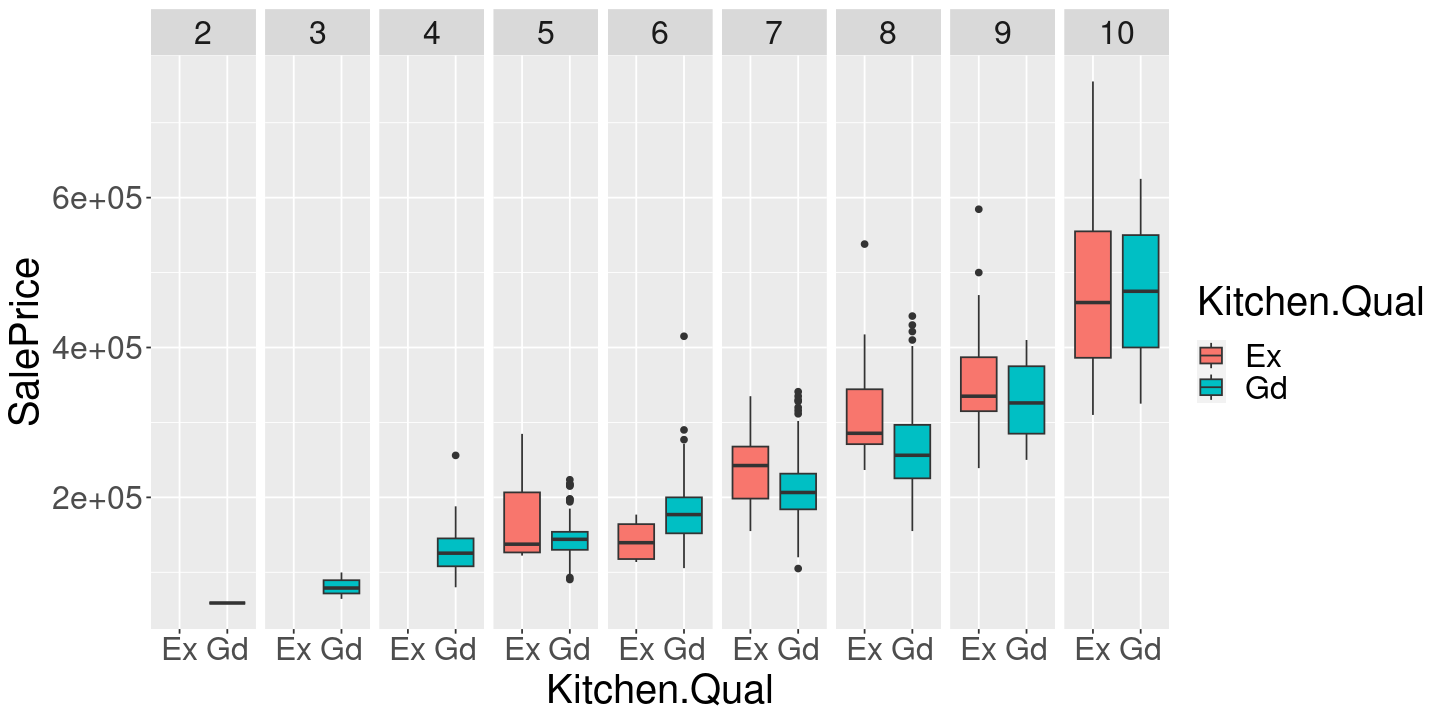

In [14]:
ames %>%
  ggplot() +
  geom_boxplot(aes(x=Kitchen.Qual, y=SalePrice, fill=Kitchen.Qual)) +
  facet_grid( ~ Overall.Qual)


In [15]:
ames %>%
    group_by(Overall.Qual, Kitchen.Qual) %>%
    summarize(mean_price=mean(SalePrice), .groups="drop") %>%
    pivot_wider(id_cols=Overall.Qual, names_from=Kitchen.Qual, values_from=mean_price) %>%
    mutate(difference=Ex - Gd)

This not only gives a very different answer to our original difference
in means, but it even gives surprising answers, such as a *negative*
value for a particular value of overall quality.

Exercise: How can you explain the difference in these results?

How can we compute these separate means as regression?

In [16]:
reg_qual <- lm(SalePrice ~ Overall.Qual : Kitchen.Qual - 1, ames)
print(summary(reg_qual))


Call:
lm(formula = SalePrice ~ Overall.Qual:Kitchen.Qual - 1, data = ames)

Residuals:
    Min      1Q  Median      3Q     Max 
-168246  -29701   -4211   22776  276754 

Coefficients: (3 not defined because of singularities)
                              Estimate Std. Error t value Pr(>|t|)    
Overall.Qual2:Kitchen.QualEx        NA         NA      NA       NA    
Overall.Qual3:Kitchen.QualEx        NA         NA      NA       NA    
Overall.Qual4:Kitchen.QualEx        NA         NA      NA       NA    
Overall.Qual5:Kitchen.QualEx    169931      16713  10.168  < 2e-16 ***
Overall.Qual6:Kitchen.QualEx    142425      23636   6.026 2.33e-09 ***
Overall.Qual7:Kitchen.QualEx    239900      13646  17.580  < 2e-16 ***
Overall.Qual8:Kitchen.QualEx    311166       9271  33.565  < 2e-16 ***
Overall.Qual9:Kitchen.QualEx    355043       6493  54.679  < 2e-16 ***
Overall.Qual10:Kitchen.QualEx   478246      13111  36.478  < 2e-16 ***
Overall.Qual2:Kitchen.QualGd     59000      47271   1.248  0.212

We can see that the estimates are the same as the means.

Let’s look at the regressor matrix that we’re constructing:

In [17]:
x <- model.matrix(SalePrice ~ Overall.Qual : Kitchen.Qual - 1, ames)

bind_cols(
    select(ames, SalePrice, Overall.Qual, Kitchen.Qual),
    x) %>%
head(15) %>% t()

## Controlling for living area

We might ask the same question about living area. Unfortunately this is
now a continuous variable.

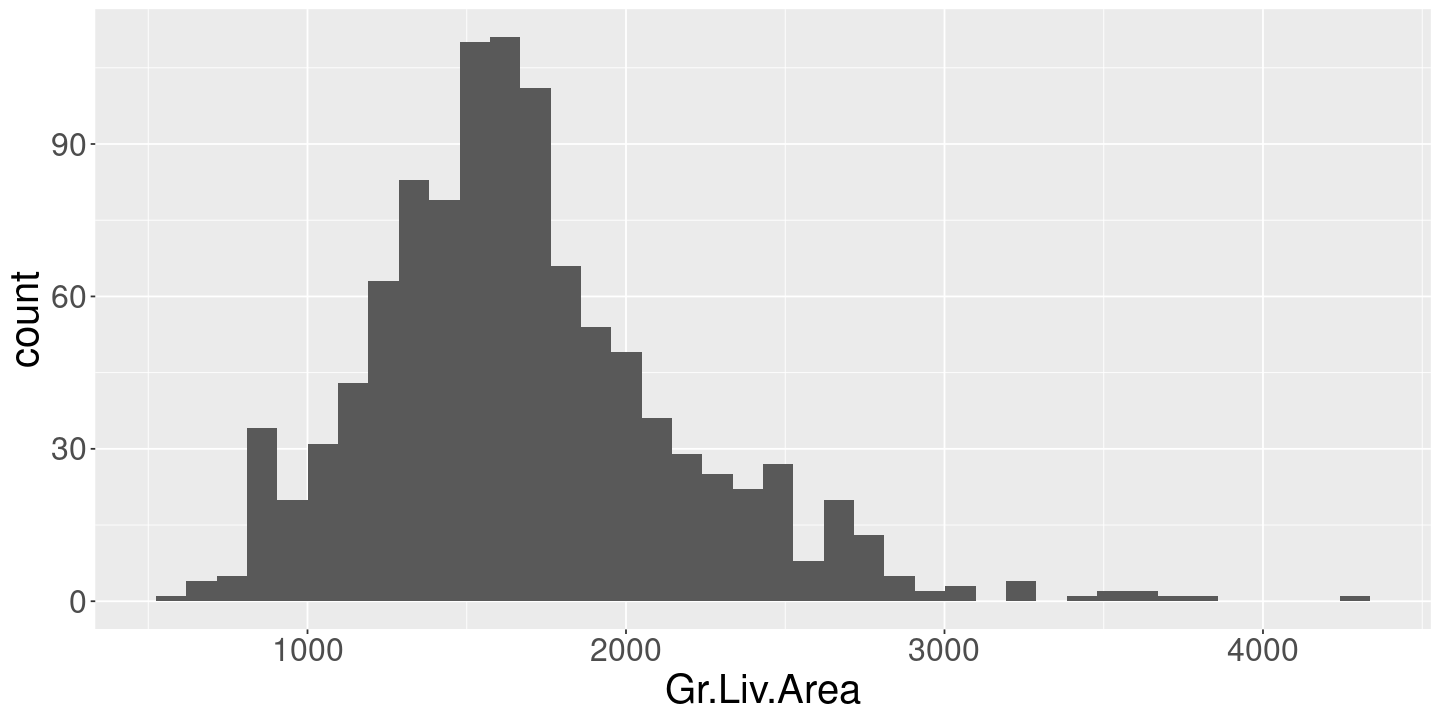

In [18]:
ames %>%
    ggplot() +
      geom_histogram(aes(x=Gr.Liv.Area), bins=40)

It no longer makes sense to look at the difference in means “for a fixed
living area,” as you can see by the scatter plot.

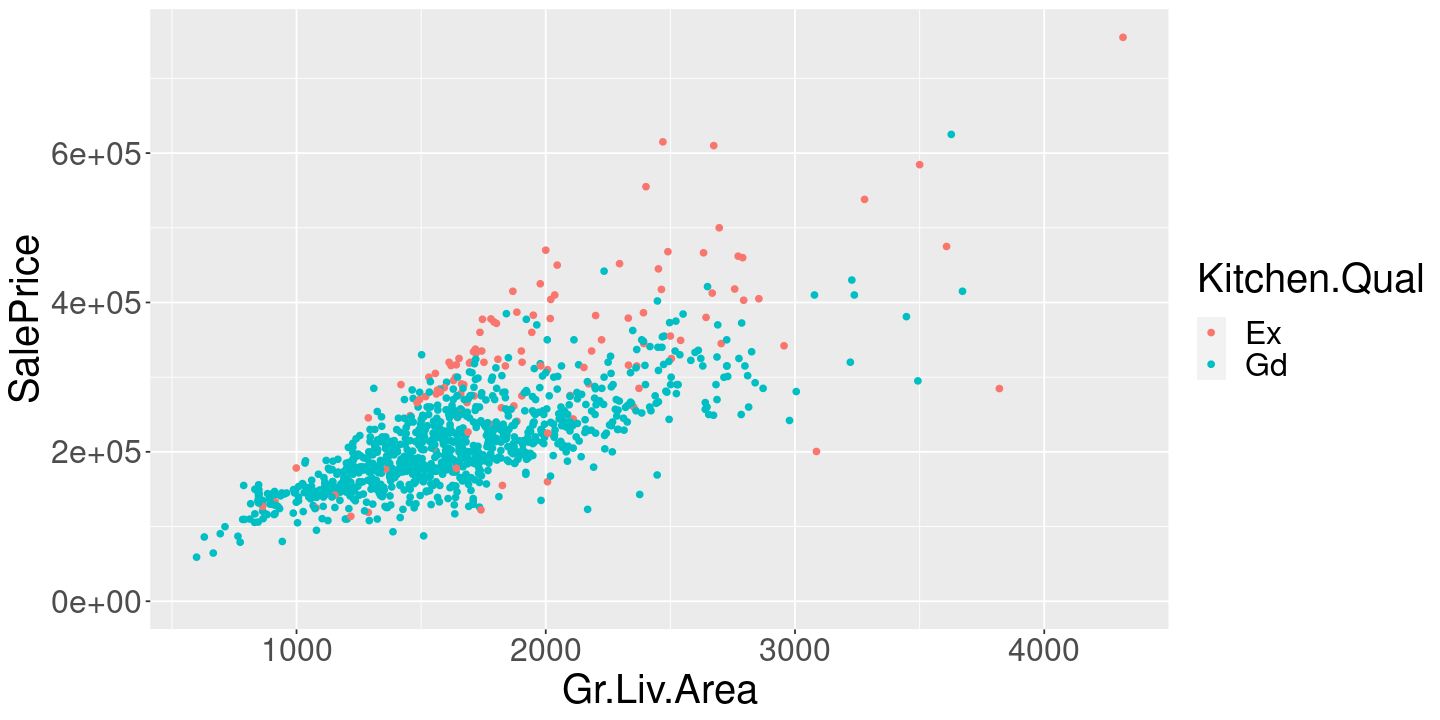

In [19]:
ames %>%
  ggplot() +
  geom_point(aes(x=Gr.Liv.Area, y=SalePrice, color=Kitchen.Qual)) +
  expand_limits(y=0)

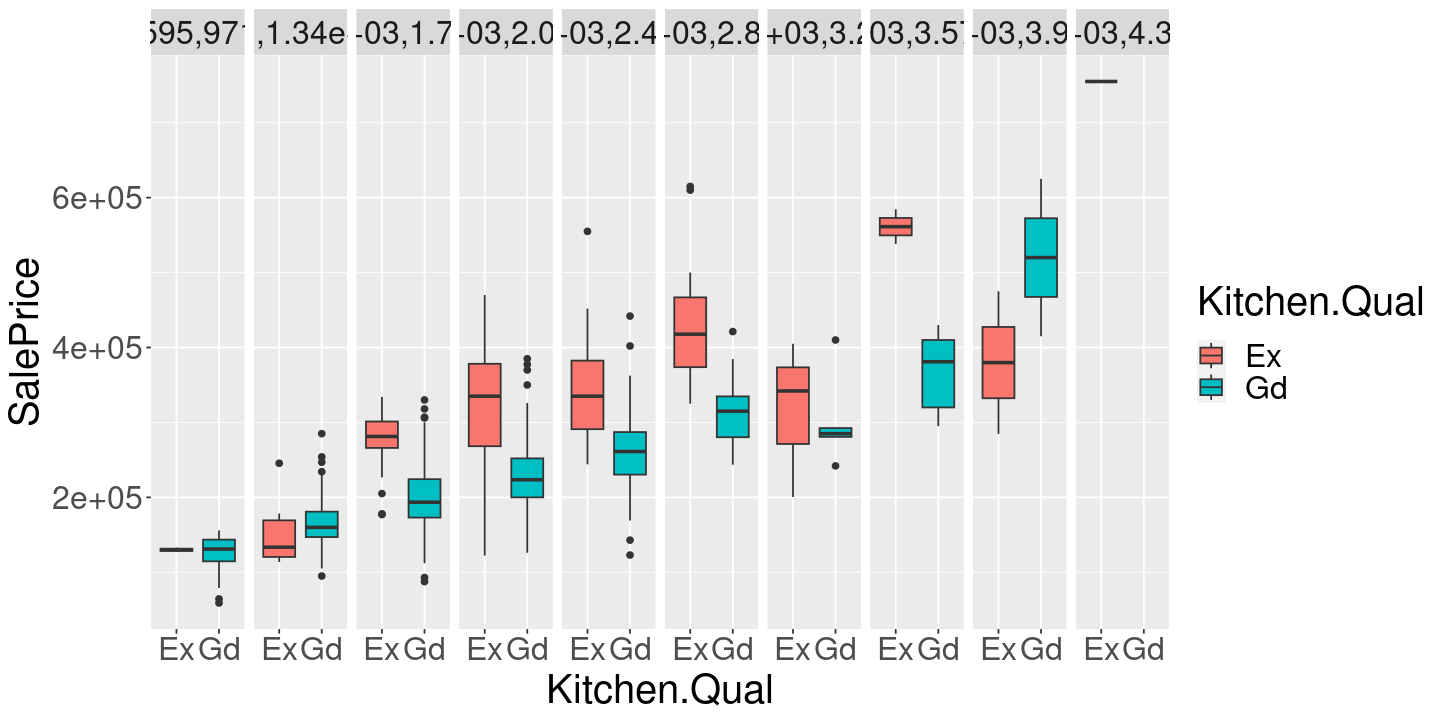

In [20]:
ames %>%
    mutate(LivingAreaBin=cut(Gr.Liv.Area, 10)) %>%
    ggplot() +
        geom_boxplot(aes(x=Kitchen.Qual, y=SalePrice, fill=Kitchen.Qual)) +
        facet_grid( ~ LivingAreaBin)


Call:
lm(formula = SalePrice ~ Gr.Liv.Area + Kitchen.Qual, data = ames)

Residuals:
    Min      1Q  Median      3Q     Max 
-238658  -24841   -2552   23240  240508 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    115200.021   7234.776   15.92   <2e-16 ***
Gr.Liv.Area       104.977      2.912   36.05   <2e-16 ***
Kitchen.QualGd -79532.676   4606.565  -17.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 45460 on 1053 degrees of freedom
Multiple R-squared:  0.6561,    Adjusted R-squared:  0.6555 
F-statistic:  1005 on 2 and 1053 DF,  p-value: < 2.2e-16


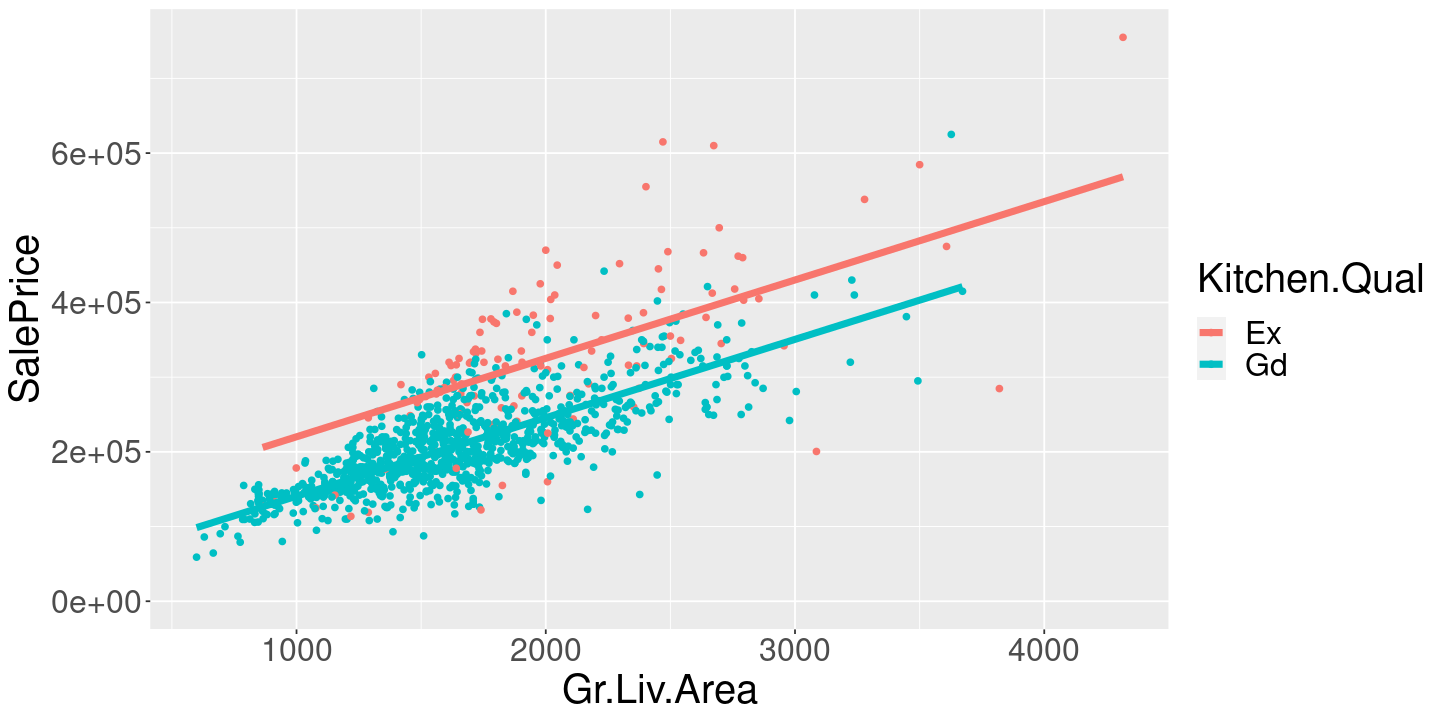

In [21]:
reg_la <- lm(SalePrice ~ Gr.Liv.Area + Kitchen.Qual, ames)
print(summary(reg_la))

ames %>%
    mutate(PredPrice=predict(reg_la, ames)) %>%
  ggplot() +
      geom_point(aes(x=Gr.Liv.Area, y=SalePrice, color=Kitchen.Qual)) +
      geom_line(aes(x=Gr.Liv.Area, y=PredPrice, color=Kitchen.Qual, group=Kitchen.Qual), lwd=2) +
      expand_limits(y=0)

Taking this seriously, we might estimate that the coefficient on
`Kitchen.QualGd` tells us the answer to our question. But the modeling
assumptions to not look reasonable. Note, for example, the particularly
bad fit of the `Ex` line for low living area houses.

## Controlling for too much

Furthermore, we can even further subdivide and try to “control” for
overall quality and living area simultaneously. This is probably closer
to what we actually want, but we have real problems with data sparsity
now.

In [ ]:
options(repr.plot.width=20, repr.plot.height=6)
ames %>%
  ggplot() +
  geom_point(aes(x=Gr.Liv.Area, y=SalePrice, color=Kitchen.Qual)) +
  facet_grid( ~ Overall.Qual) +
  expand_limits(y=0) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
options(repr.plot.width=12, repr.plot.height=6)


This is getting difficult. What about a linear model?

In [ ]:
big_reg <-
    lm(SalePrice ~ Gr.Liv.Area + Kitchen.Qual + Overall.Qual, ames)

print(summary(big_reg))

One way to interpret this is via making predictions for a given house,
one with a renovated kitchen and one without.

In [ ]:
sample_house <- 
    filter(ames, Kitchen.Qual == "Gd") %>% 
    sample_n(1)

sample_house_reno <- sample_house %>% mutate(Kitchen.Qual="Ex")

predict(big_reg, sample_house_reno) - predict(big_reg, sample_house)  

Of course, the problem is that we may get different answers depending on
what regression we run:

In [ ]:
lm(SalePrice ~ Gr.Liv.Area + Kitchen.Qual, ames) %>% 
    summary()

# Prediction

What if we just asked a different question: can we predict the cost of a
house using kitchen quality?

In [ ]:
ames %>%
  ggplot() +
      geom_boxplot(aes(x=Kitchen.Qual, y=SalePrice, fill=Kitchen.Qual))+
      expand_limits(y=0)

In [ ]:
all_rows <- 1:nrow(ames)
train_rows <- sample(all_rows, floor(nrow(ames) / 2), replace=FALSE)
test_rows <- setdiff(all_rows, train_rows) 
print(length(train_rows) / nrow(ames)) # Sanity check

ames_train <- ames[train_rows, ]

In [ ]:
means_df <-
    ames_train %>%
        group_by(Overall.Qual, Kitchen.Qual) %>%
        summarize(mean_price=mean(SalePrice), .groups="drop")

overall_mean <- mean(ames_train$SalePrice)

print(means_df)
print(overall_mean)

In [ ]:
ames_test <- 
    ames[test_rows, ] %>%
    select(SalePrice, Overall.Qual, Kitchen.Qual) %>%
    inner_join(means_df, by=c("Overall.Qual", "Kitchen.Qual")) %>%  # Note: drops missing values!
    mutate(err_pred=SalePrice - mean_price, err_base=SalePrice - overall_mean) %>%
    summarize(rmse_pred=sqrt(mean(err_pred^2)), rmse_base=sqrt(mean(err_base^2))) 

print(ames_test)

Exercise: When we’re doing prediction, do we care whether or not we have
found the “true” cost effect of renovating your kitchen?